In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
%load_ext autoreload
%autoreload 2

# This tutorial explains the basic pipline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [3]:
import agentnet.experiments.boolean_reasoning as experiment
print experiment.__doc__


This is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1, X2, X3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 is true if X1
 - Y2 is true if not X1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will learn the policy
1. Check X1
2. If X1, check Y1, else Y2

The experiment 

In [4]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step RNN
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory.rnn import RNNCell
from agentnet.agent import Agent

In [6]:
import lasagne

#64 hidden neurons
n_hid=64


observation_size = (None,)+tuple(env.observation_shapes)

observation_layer = lasagne.layers.InputLayer(observation_size,name="obs_input")
prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
rnn = RNNCell(prev_state_layer,
                           observation_layer,
                           name="rnn0")

#q_eval
q_eval = lasagne.layers.DenseLayer(rnn,
                                   num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")

#resolver
epsilon = theano.shared(np.float32(0.1),name="e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(observation_layer,
              {rnn:prev_state_layer},
              q_eval,resolver)


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[rnn0.hid_to_hid.W,
 rnn0.hid_to_hid.b,
 rnn0.input0_to_hid.W,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* Such sessions are represented as tensors with dimensions matching pattern [batch_session_i, time_tick, ...]
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [8]:
#produce interaction sequences of length <= 10
(state_seq,),observation_seq,agent_state,action_seq,qvalues_seq = agent.get_sessions(
    env,
    session_length=10,
    batch_size=env.batch_size,
)


hidden_seq = agent_state[rnn]

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights

#### Define loss functions

In [9]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning


#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(1),name = 'q_learning_gamma')


squarred_Qerror = qlearning.get_elementwise_objective(
    qvalues_seq,
    action_seq,
    rewards_seq,
    is_alive_seq,
    gamma_or_gammas=gamma,)


mse_Qloss = squarred_Qerror.sum(axis = 1).mean()

In [10]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [11]:
loss = mse_Qloss + reg_l2

#### Compute weight updates

In [12]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

#### Some auxilary evaluation metrics

In [13]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [14]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_Qloss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [15]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   action_names=env.feature_names,
                  
                  plot_policy = with_plots)

session # 0
 Y2(qv = 1.71950578515) -> 3.0 |  Y2(qv = 1.70756777298) -> -0.5 |  Y2(qv = 1.63698375836) -> -0.5 |  Y2(qv = 1.6381646216) -> -0.5 |  Y2(qv = 1.64118717783) -> -0.5 |  Y2(qv = 1.64116446125) -> -0.5 |  X3(qv = -0.795488056774) -> 1.0 |  Y2(qv = 1.63242271078) -> -0.5 |  Y2(qv = 1.66136166062) -> -0.5 |  Y2(qv = 1.64194140499) -> -0.5 | reached max session length


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


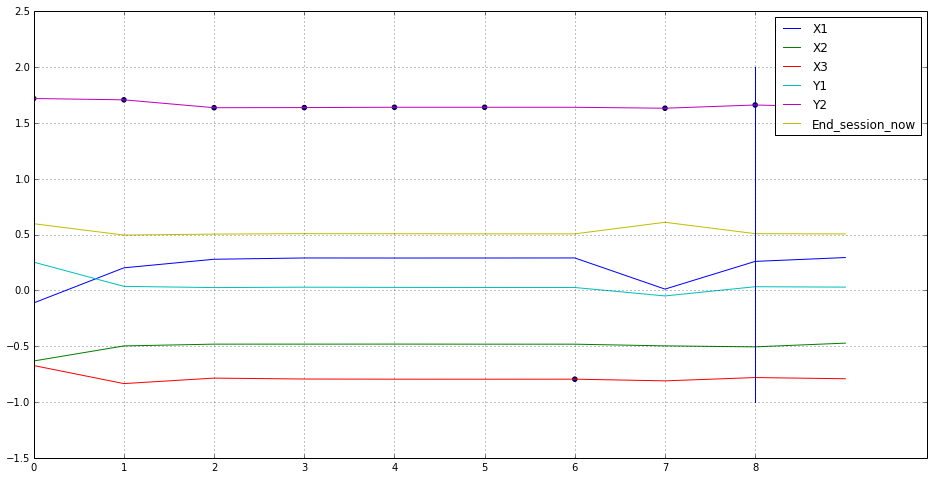

In [16]:
#visualize untrained network performance (which is mostly random)
env.generate_new_data_batch(1)
display_sessions(with_plots=True)

# Training loop

In [17]:
from agentnet.display import Metrics
score_log = Metrics()

In [18]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100,loss 9.33298, epsilon 0.96275, rewards: ( e-greedy -0.09500, greedy -0.49000) 
rec 9.242 reg 0.091
epoch 200,loss 11.24442, epsilon 0.92696, rewards: ( e-greedy -0.19550, greedy -0.53100) 
rec 11.154 reg 0.091
epoch 300,loss 6.78700, epsilon 0.89257, rewards: ( e-greedy -0.18595, greedy -0.53790) 
rec 6.697 reg 0.090
epoch 400,loss 9.55289, epsilon 0.85954, rewards: ( e-greedy -0.19736, greedy -0.42411) 
rec 9.463 reg 0.090
epoch 500,loss 7.03849, epsilon 0.82779, rewards: ( e-greedy -0.21762, greedy -0.38170) 
rec 6.949 reg 0.089
epoch 600,loss 6.89226, epsilon 0.79730, rewards: ( e-greedy -0.23586, greedy -0.34353) 
rec 6.804 reg 0.088
epoch 700,loss 10.71261, epsilon 0.76799, rewards: ( e-greedy -0.18727, greedy -0.36918) 
rec 10.625 reg 0.088
epoch 800,loss 9.74516, epsilon 0.73984, rewards: ( e-greedy -0.13854, greedy -0.45226) 
rec 9.658 reg 0.087
epoch 900,loss 9.19676, epsilon 0.71279, rewards: ( e-greedy -0.18469, greedy -0.34703) 
rec 9.110 reg 0.087
epoch 1000,loss

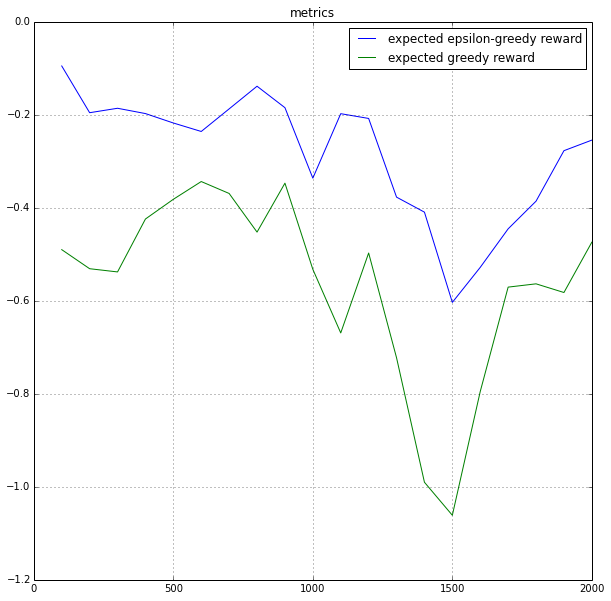

Random session examples
session # 0
 X2(qv = 0.213922964024) -> -1.0 |  X2(qv = -0.274839598009) -> -0.5 |  Y2(qv = 0.330455943709) -> -3.0 |  Y1(qv = 0.257357964668) -> 3.0 |  End_session_now(qv = 0.0385863871263) -> 0.0 | 



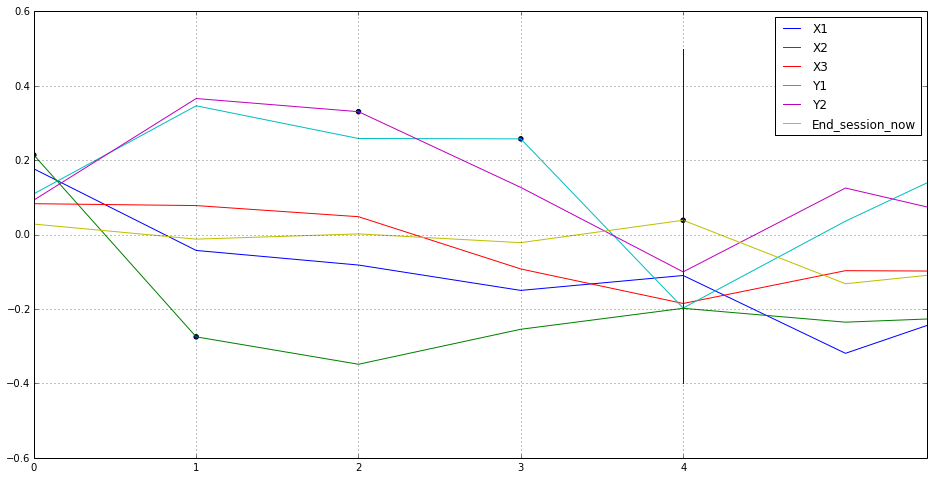

session # 1
 X1(qv = 0.176794746041) -> -1.0 |  X2(qv = -0.169009005678) -> -1.0 |  Y2(qv = 0.308469249346) -> 3.0 |  Y1(qv = 0.000754039875863) -> -3.0 |  Y2(qv = 0.253015552328) -> -0.5 |  End_session_now(qv = -0.0223276795281) -> 0.0 | 



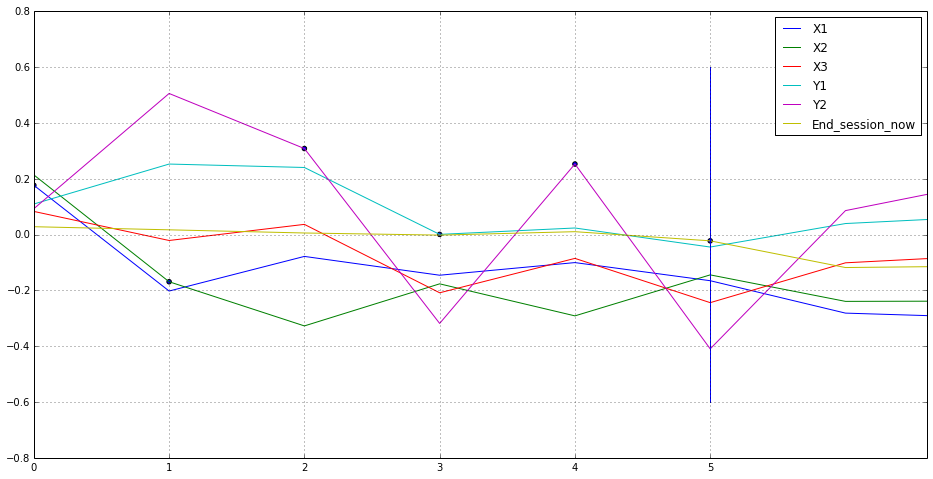

session # 2
 X3(qv = 0.0830847187202) -> -1.0 |  X2(qv = -0.171093006778) -> -1.0 |  Y2(qv = 0.283707111039) -> 3.0 |  End_session_now(qv = -8.91522968227e-05) -> 0.0 | 



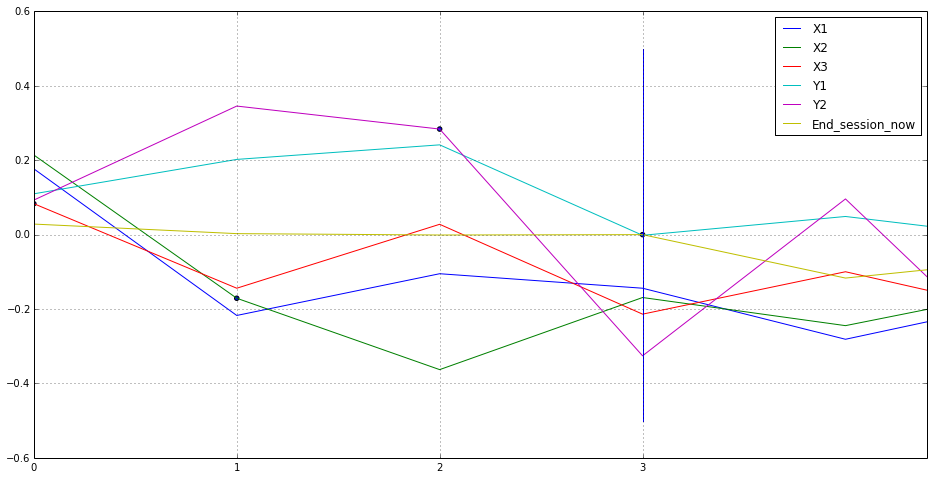

epoch 2100,loss 11.08269, epsilon 0.46012, rewards: ( e-greedy -0.24400, greedy -0.38155) 
rec 10.997 reg 0.086
epoch 2200,loss 11.62016, epsilon 0.44404, rewards: ( e-greedy -0.15960, greedy -0.10840) 
rec 11.533 reg 0.087
epoch 2300,loss 9.52244, epsilon 0.42859, rewards: ( e-greedy -0.03864, greedy 0.08244) 
rec 9.434 reg 0.088
epoch 2400,loss 11.56600, epsilon 0.41375, rewards: ( e-greedy -0.04478, greedy 0.24420) 
rec 11.476 reg 0.090
epoch 2500,loss 11.18707, epsilon 0.39949, rewards: ( e-greedy -0.10530, greedy 0.34478) 
rec 11.095 reg 0.092
epoch 2600,loss 10.33332, epsilon 0.38578, rewards: ( e-greedy -0.13977, greedy 0.63030) 
rec 10.239 reg 0.094
epoch 2700,loss 8.69274, epsilon 0.37262, rewards: ( e-greedy 0.09421, greedy 0.90727) 
rec 8.596 reg 0.097
epoch 2800,loss 9.79401, epsilon 0.35997, rewards: ( e-greedy 0.15979, greedy 0.97654) 
rec 9.694 reg 0.100
epoch 2900,loss 10.99769, epsilon 0.34781, rewards: ( e-greedy 0.08381, greedy 0.91889) 
rec 10.895 reg 0.103
epoch 30

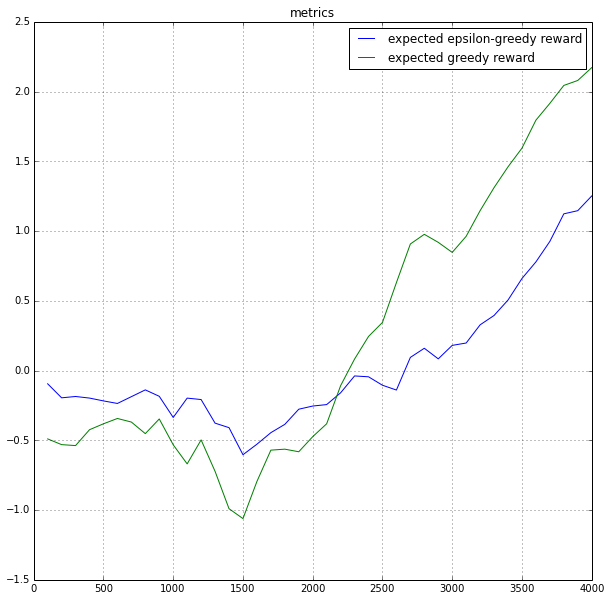

Random session examples
session # 0
 X1(qv = 2.47001652387) -> 1.0 |  Y1(qv = 2.22116116647) -> 3.0 |  End_session_now(qv = 0.00661923944685) -> 0.0 | 



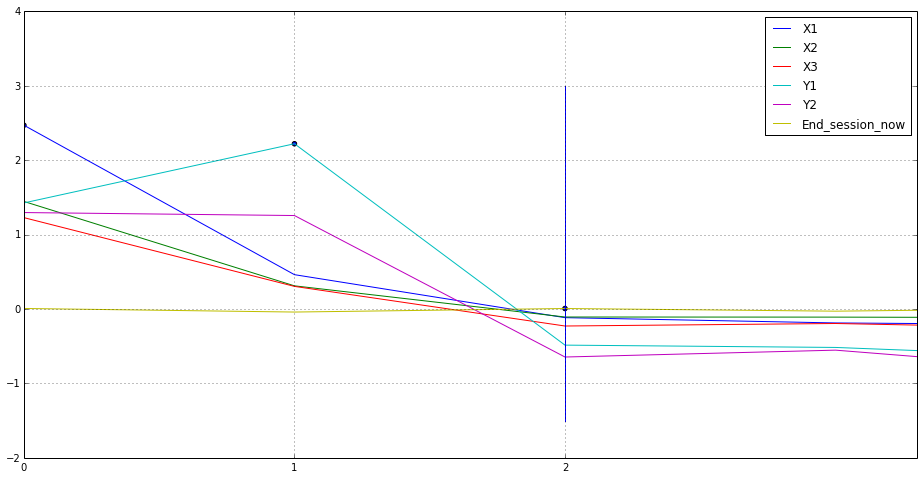

session # 1
 X1(qv = 2.47001652387) -> 1.0 |  Y1(qv = 2.22116116647) -> 3.0 |  End_session_now(qv = 0.00661923944685) -> 0.0 | 



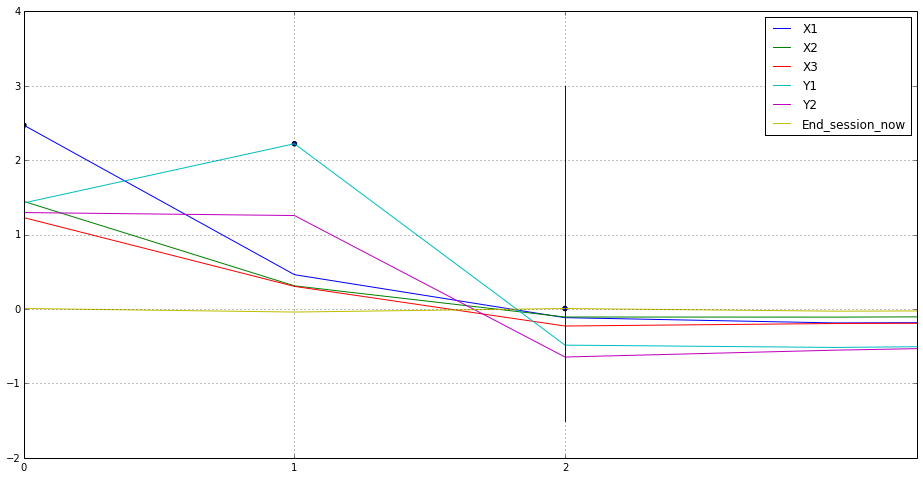

session # 2
 X1(qv = 2.47001652387) -> 1.0 |  Y1(qv = 2.22116116647) -> 3.0 |  End_session_now(qv = 0.00661923944685) -> 0.0 | 



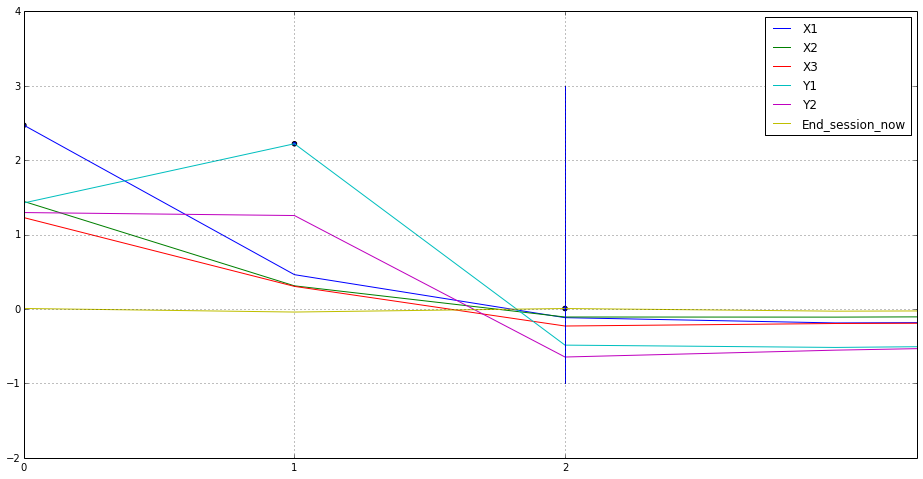

epoch 4100,loss 4.75315, epsilon 0.23428, rewards: ( e-greedy 1.34130, greedy 2.25435) 
rec 4.633 reg 0.120
epoch 4200,loss 4.29318, epsilon 0.22706, rewards: ( e-greedy 1.45717, greedy 2.26892) 
rec 4.173 reg 0.120
epoch 4300,loss 3.37544, epsilon 0.22011, rewards: ( e-greedy 1.47145, greedy 2.31203) 
rec 3.254 reg 0.121
epoch 4400,loss 3.80137, epsilon 0.21344, rewards: ( e-greedy 1.52431, greedy 2.33082) 
rec 3.680 reg 0.122
epoch 4500,loss 3.29261, epsilon 0.20703, rewards: ( e-greedy 1.48687, greedy 2.31774) 
rec 3.170 reg 0.123
epoch 4600,loss 4.75152, epsilon 0.20088, rewards: ( e-greedy 1.46319, greedy 2.40597) 
rec 4.628 reg 0.124
epoch 4700,loss 1.07584, epsilon 0.19496, rewards: ( e-greedy 1.53687, greedy 2.44537) 
rec 0.951 reg 0.124
epoch 4800,loss 6.56015, epsilon 0.18928, rewards: ( e-greedy 1.53818, greedy 2.52083) 
rec 6.435 reg 0.125
epoch 4900,loss 4.42184, epsilon 0.18382, rewards: ( e-greedy 1.58936, greedy 2.54875) 
rec 4.295 reg 0.126
epoch 5000,loss 3.43049, eps

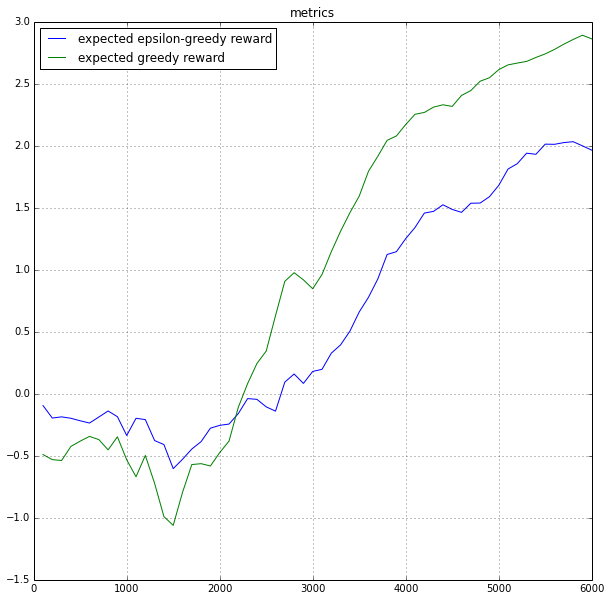

Random session examples
session # 0
 X1(qv = 2.77541293882) -> -1.0 |  Y2(qv = 2.95879905465) -> 3.0 |  End_session_now(qv = 0.0148491469425) -> 0.0 | 



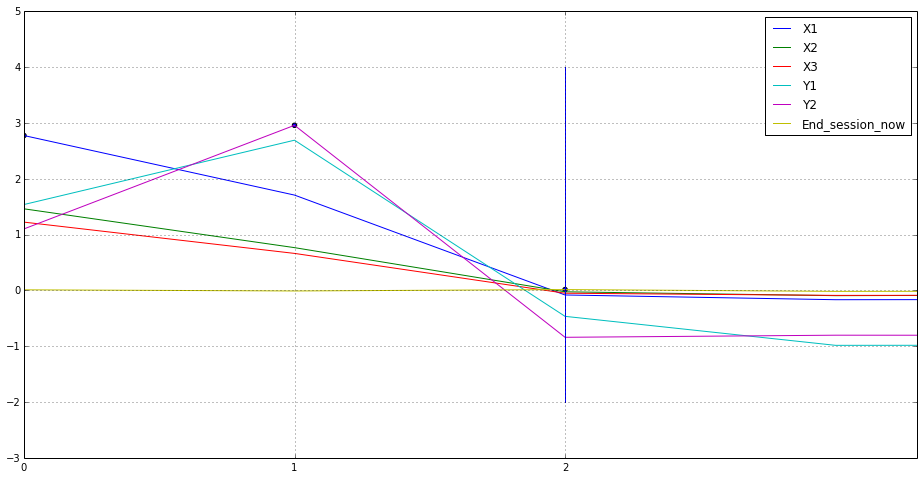

session # 1
 X1(qv = 2.77541293882) -> -1.0 |  Y2(qv = 2.95879905465) -> 3.0 |  End_session_now(qv = 0.0148491469425) -> 0.0 | 



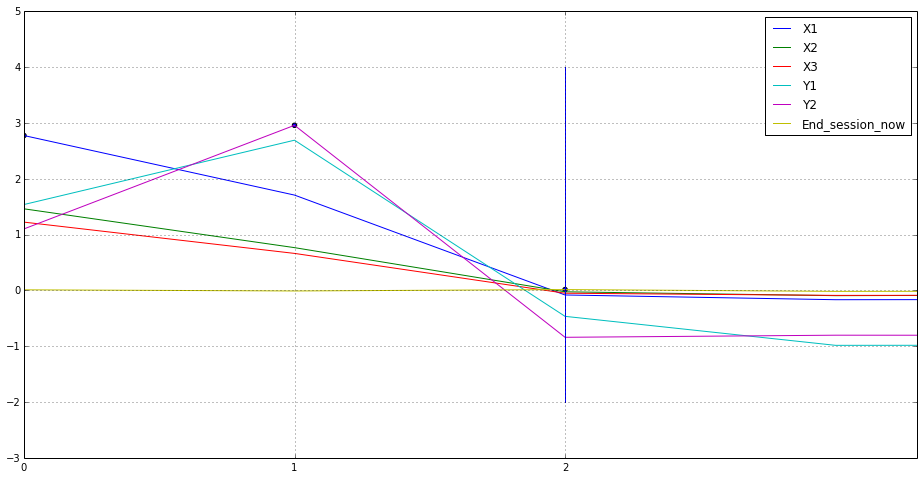

session # 2
 X2(qv = 1.46190800473) -> -1.0 |  Y2(qv = 1.65321898992) -> -3.0 |  Y2(qv = 0.446055259481) -> -0.5 |  X1(qv = -0.20037024514) -> 1.0 |  Y1(qv = 0.0537383802544) -> 3.0 |  End_session_now(qv = 0.00491326337396) -> 0.0 | 



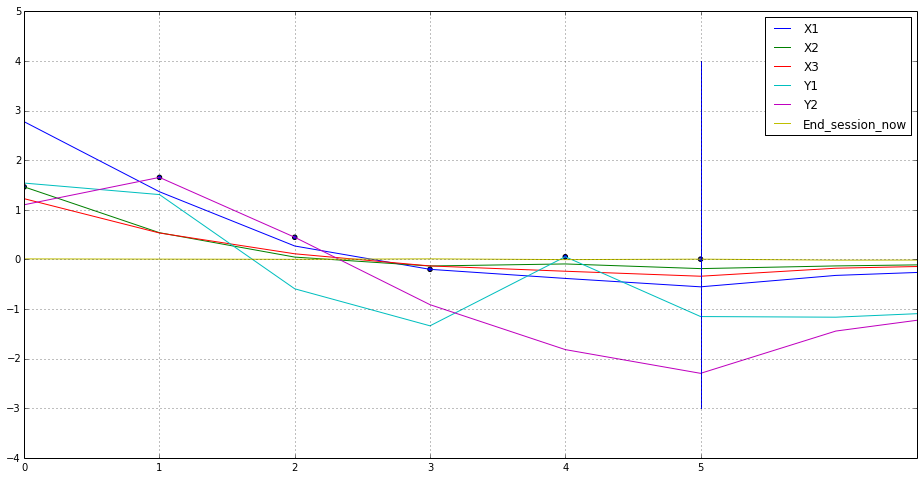

epoch 6100,loss 4.23015, epsilon 0.13280, rewards: ( e-greedy 1.95342, greedy 2.83628) 
rec 4.096 reg 0.135
epoch 6200,loss 2.68030, epsilon 0.12956, rewards: ( e-greedy 1.96807, greedy 2.79265) 
rec 2.545 reg 0.135
epoch 6300,loss 3.95982, epsilon 0.12644, rewards: ( e-greedy 1.98127, greedy 2.76339) 
rec 3.824 reg 0.136
epoch 6400,loss 1.88942, epsilon 0.12344, rewards: ( e-greedy 2.00814, greedy 2.72705) 
rec 1.753 reg 0.136
epoch 6500,loss 1.60619, epsilon 0.12056, rewards: ( e-greedy 2.04233, greedy 2.73434) 
rec 1.469 reg 0.137
epoch 6600,loss 1.40860, epsilon 0.11779, rewards: ( e-greedy 2.15309, greedy 2.78091) 
rec 1.271 reg 0.138
epoch 6700,loss 1.66654, epsilon 0.11513, rewards: ( e-greedy 2.16778, greedy 2.78282) 
rec 1.528 reg 0.138
epoch 6800,loss 1.41982, epsilon 0.11258, rewards: ( e-greedy 2.21101, greedy 2.78454) 
rec 1.281 reg 0.139
epoch 6900,loss 1.66561, epsilon 0.11013, rewards: ( e-greedy 2.26991, greedy 2.78608) 
rec 1.526 reg 0.140
epoch 7000,loss 1.26046, eps

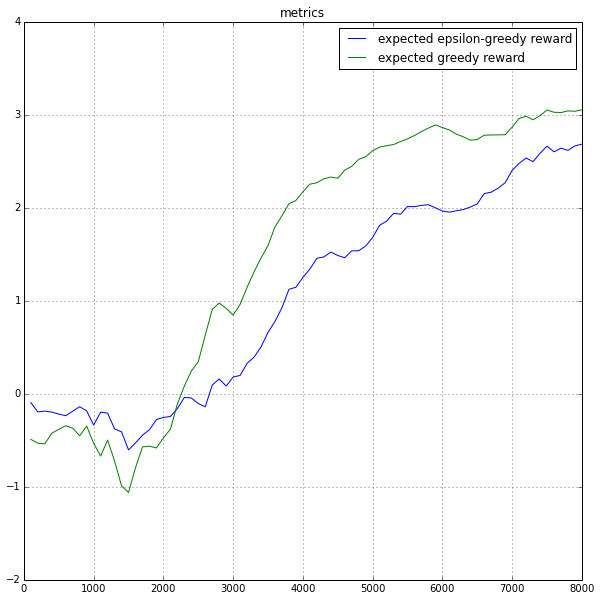

Random session examples
session # 0
 Y1(qv = 1.50216469631) -> 3.0 |  X1(qv = 0.991507648924) -> 1.0 |  Y1(qv = 1.04379988979) -> -0.5 |  End_session_now(qv = -0.0141256518229) -> 0.0 | 



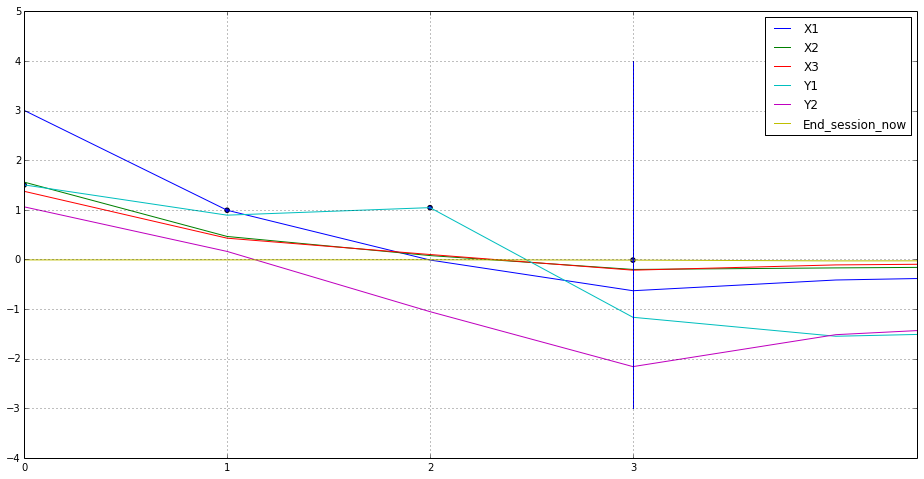

session # 1
 X1(qv = 3.00383668435) -> 1.0 |  Y1(qv = 2.99540017259) -> 3.0 |  X3(qv = 0.0732154158928) -> 1.0 |  X1(qv = -0.513232880078) -> -0.5 |  Y1(qv = 0.348407347308) -> -0.5 |  End_session_now(qv = -0.0179169359449) -> 0.0 | 



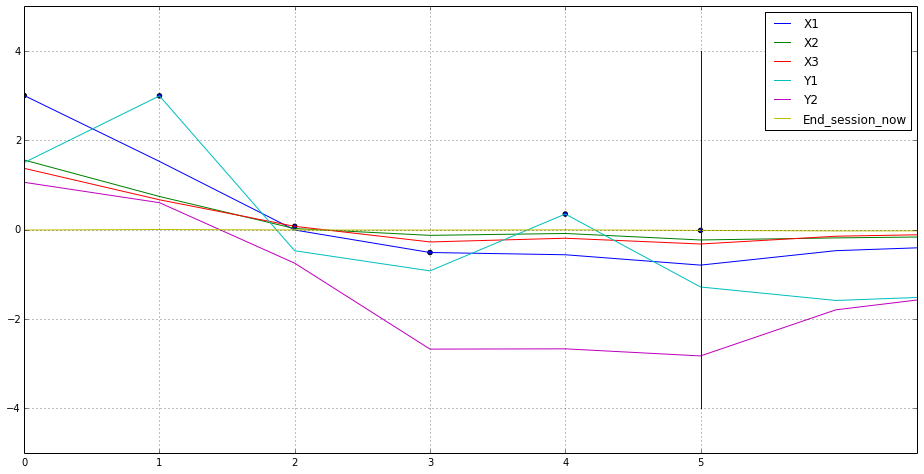

session # 2
 X1(qv = 3.00383668435) -> -1.0 |  Y2(qv = 3.05877346932) -> 3.0 |  X3(qv = 0.0809500537237) -> -1.0 |  End_session_now(qv = -0.00760112650176) -> 0.0 | 



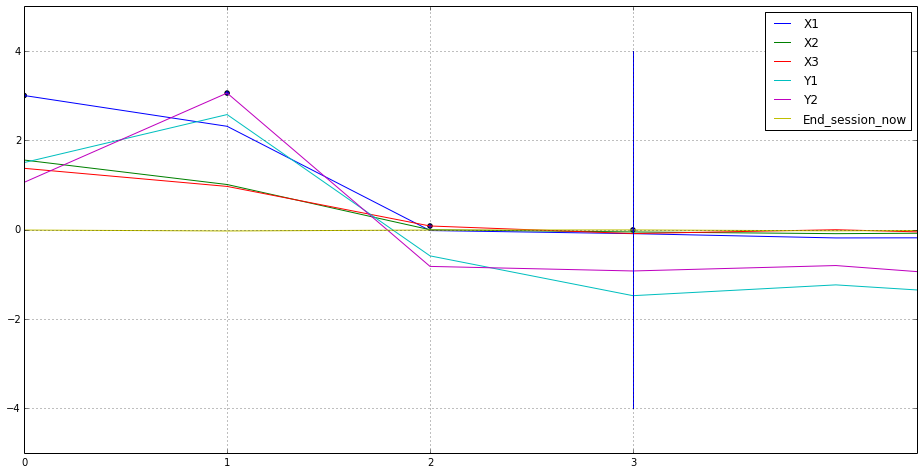

epoch 8100,loss 3.27356, epsilon 0.08721, rewards: ( e-greedy 2.61070, greedy 3.00862) 
rec 3.129 reg 0.144
epoch 8200,loss 1.64480, epsilon 0.08575, rewards: ( e-greedy 2.59963, greedy 2.96776) 
rec 1.500 reg 0.144
epoch 8300,loss 2.07022, epsilon 0.08435, rewards: ( e-greedy 2.56967, greedy 2.97099) 
rec 1.925 reg 0.145
epoch 8400,loss 1.25030, epsilon 0.08300, rewards: ( e-greedy 2.59270, greedy 2.95389) 
rec 1.105 reg 0.145
epoch 8500,loss 1.00803, epsilon 0.08170, rewards: ( e-greedy 2.67343, greedy 2.99850) 
rec 0.863 reg 0.145
epoch 8600,loss 1.11817, epsilon 0.08046, rewards: ( e-greedy 2.66609, greedy 2.95865) 
rec 0.973 reg 0.145
epoch 8700,loss 2.51166, epsilon 0.07927, rewards: ( e-greedy 2.56448, greedy 2.86278) 
rec 2.366 reg 0.146
epoch 8800,loss 1.20485, epsilon 0.07812, rewards: ( e-greedy 2.58803, greedy 2.87651) 
rec 1.058 reg 0.146
epoch 8900,loss 1.47627, epsilon 0.07702, rewards: ( e-greedy 2.59423, greedy 2.88885) 
rec 1.330 reg 0.147
epoch 9000,loss 1.28547, eps

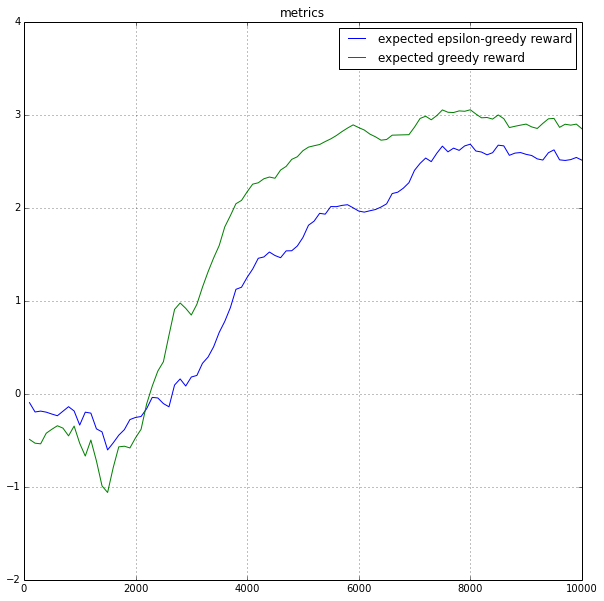

Random session examples
session # 0
 X1(qv = 2.96447649982) -> -1.0 |  Y2(qv = 3.05096873709) -> 3.0 |  End_session_now(qv = 0.0120261313703) -> 0.0 | 



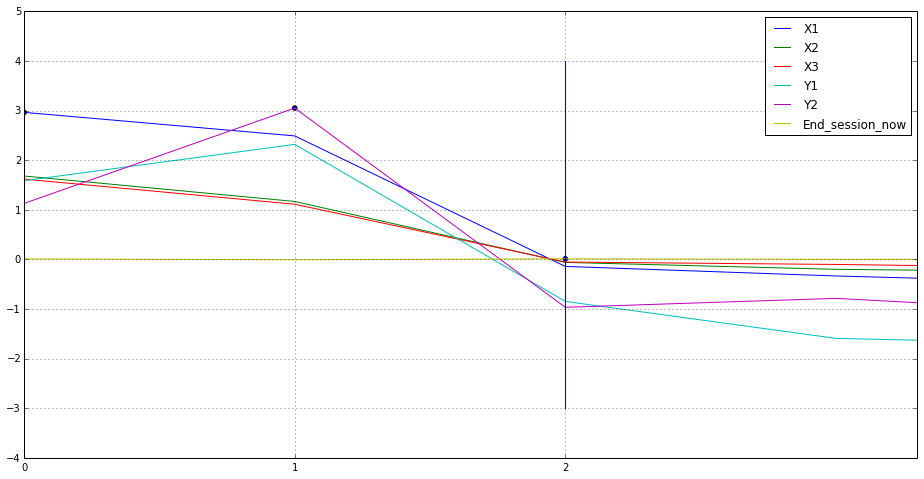

session # 1
 X1(qv = 2.96447649982) -> -1.0 |  Y2(qv = 3.05096873709) -> 3.0 |  End_session_now(qv = 0.0120261313703) -> 0.0 | 



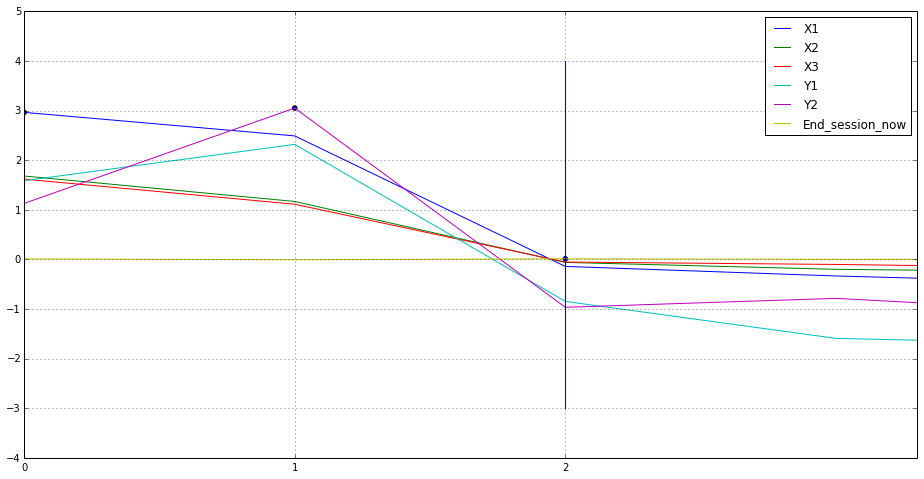

session # 2
 X1(qv = 2.96447649982) -> -1.0 |  Y2(qv = 3.05096873709) -> 3.0 |  End_session_now(qv = 0.0120261313703) -> 0.0 | 



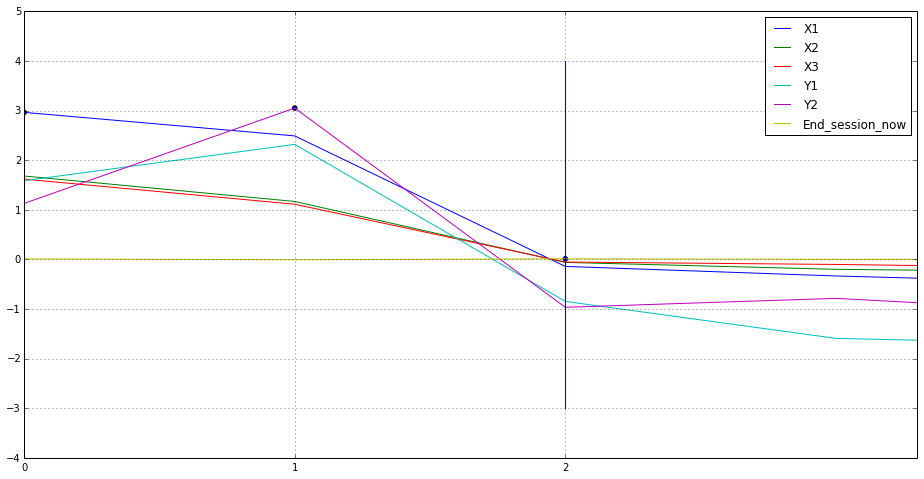

In [19]:
n_epochs = 10000
batch_size=10

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

        
    #visualize learning curve and sample sessions
    if epoch_counter %2000 ==0:
        print "Learning curves:"
        score_log.plot()
        
        print "Random session examples"
        env.generate_new_data_batch(3)
        display_sessions(with_plots=True)



        
        
    epoch_counter  +=1


# Evaluate results

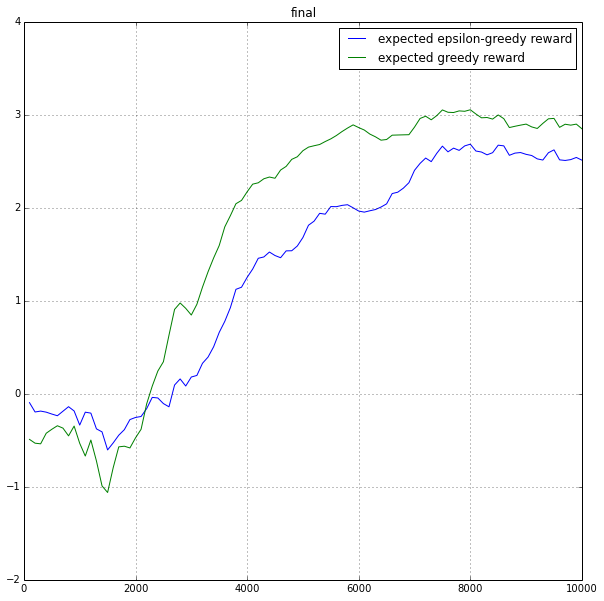

In [20]:
score_log.plot("final")

Random session examples
session # 0
 X1(qv = 2.96447649982) -> 1.0 |  Y1(qv = 2.96180767134) -> 3.0 |  End_session_now(qv = 0.013064016017) -> 0.0 | 



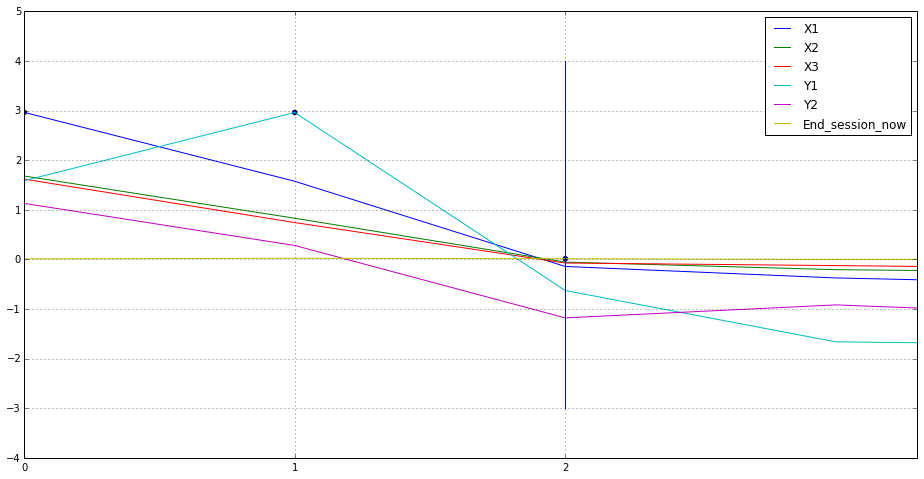

session # 1
 X1(qv = 2.96447649982) -> -1.0 |  Y2(qv = 3.05096873709) -> 3.0 |  End_session_now(qv = 0.0120261313703) -> 0.0 | 



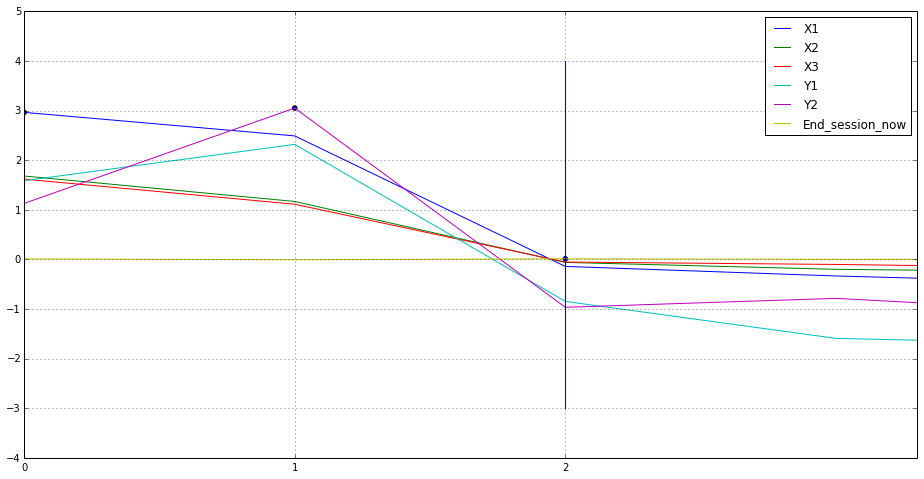

session # 2
 X1(qv = 2.96447649982) -> -1.0 |  Y2(qv = 3.05096873709) -> 3.0 |  End_session_now(qv = 0.0120261313703) -> 0.0 | 



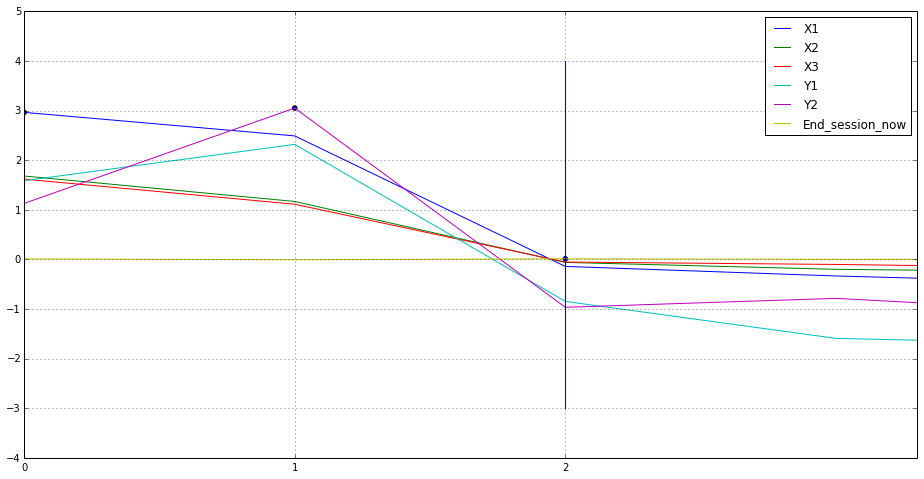

session # 3
 X1(qv = 2.96447649982) -> -1.0 |  Y2(qv = 3.05096873709) -> 3.0 |  End_session_now(qv = 0.0120261313703) -> 0.0 | 



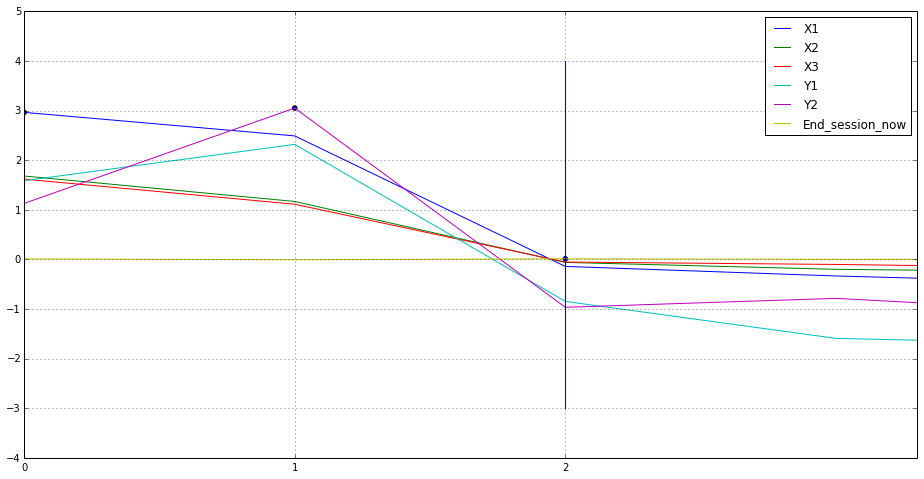

session # 4
 X1(qv = 2.96447649982) -> -1.0 |  Y2(qv = 3.05096873709) -> 3.0 |  End_session_now(qv = 0.0120261313703) -> 0.0 | 



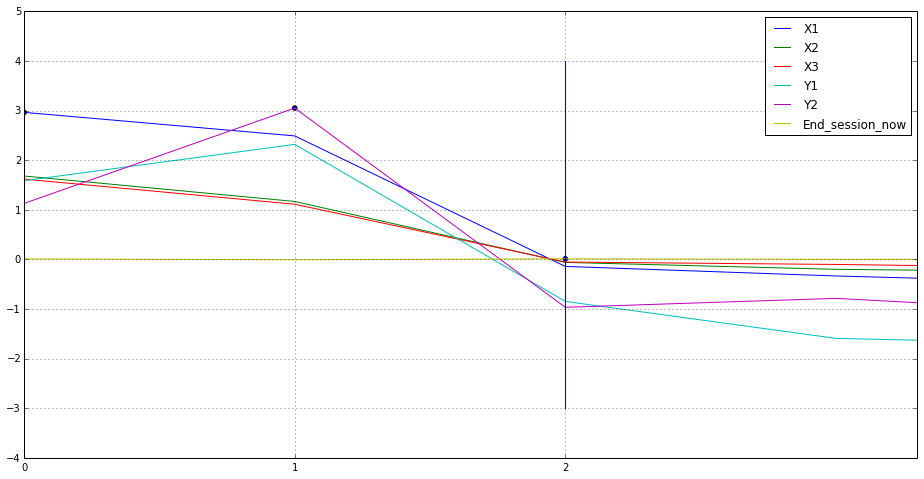

session # 5
 X1(qv = 2.96447649982) -> 1.0 |  Y1(qv = 2.96180767134) -> 3.0 |  End_session_now(qv = 0.013064016017) -> 0.0 | 



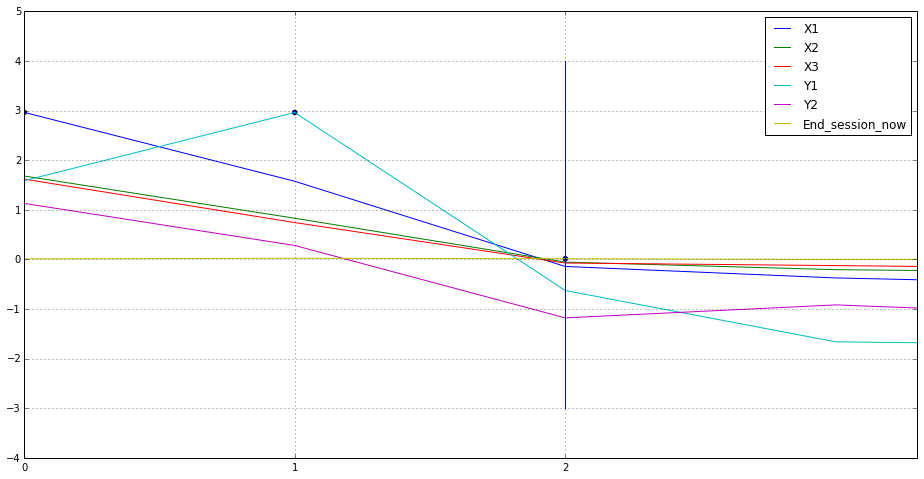

session # 6
 X1(qv = 2.96447649982) -> -1.0 |  Y2(qv = 3.05096873709) -> 3.0 |  End_session_now(qv = 0.0120261313703) -> 0.0 | 



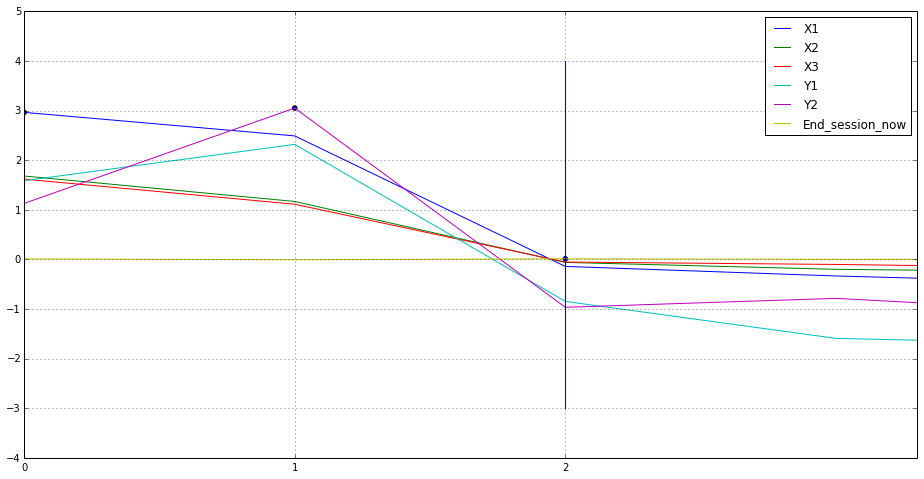

session # 7
 X1(qv = 2.96447649982) -> 1.0 |  Y1(qv = 2.96180767134) -> 3.0 |  End_session_now(qv = 0.013064016017) -> 0.0 | 



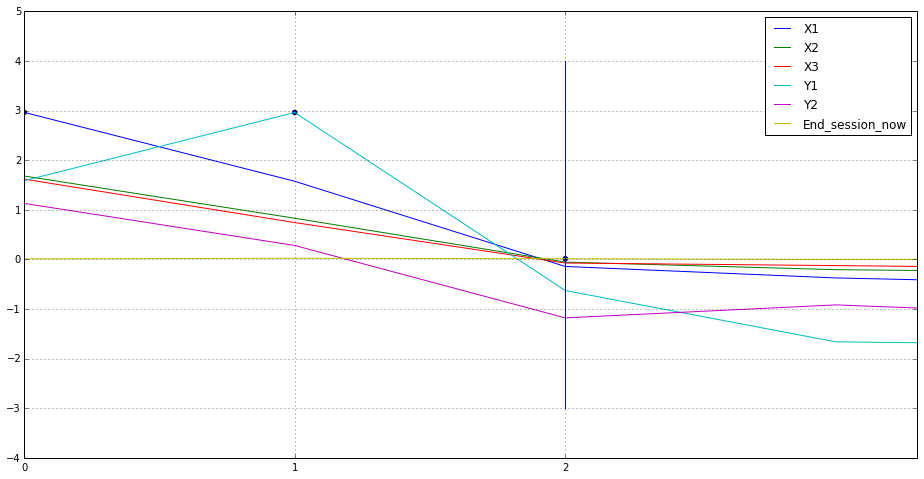

session # 8
 X1(qv = 2.96447649982) -> -1.0 |  Y2(qv = 3.05096873709) -> 3.0 |  End_session_now(qv = 0.0120261313703) -> 0.0 | 



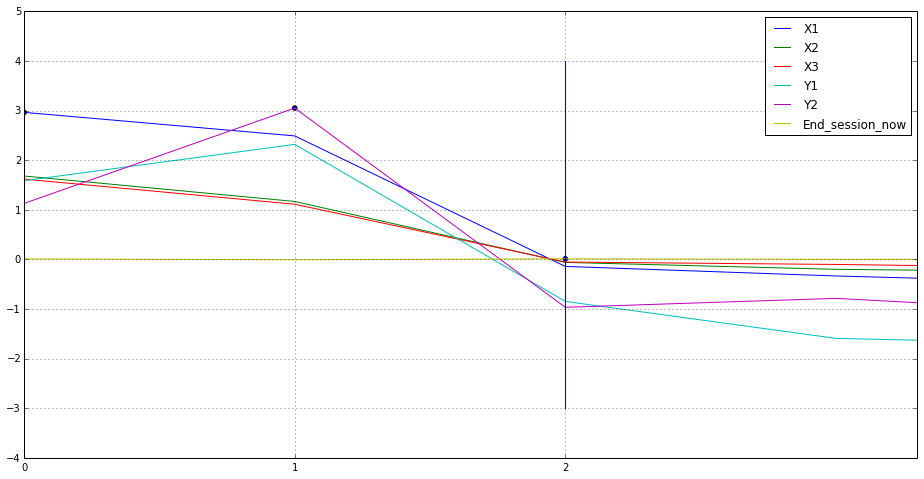

session # 9
 X1(qv = 2.96447649982) -> 1.0 |  Y1(qv = 2.96180767134) -> 3.0 |  End_session_now(qv = 0.013064016017) -> 0.0 | 



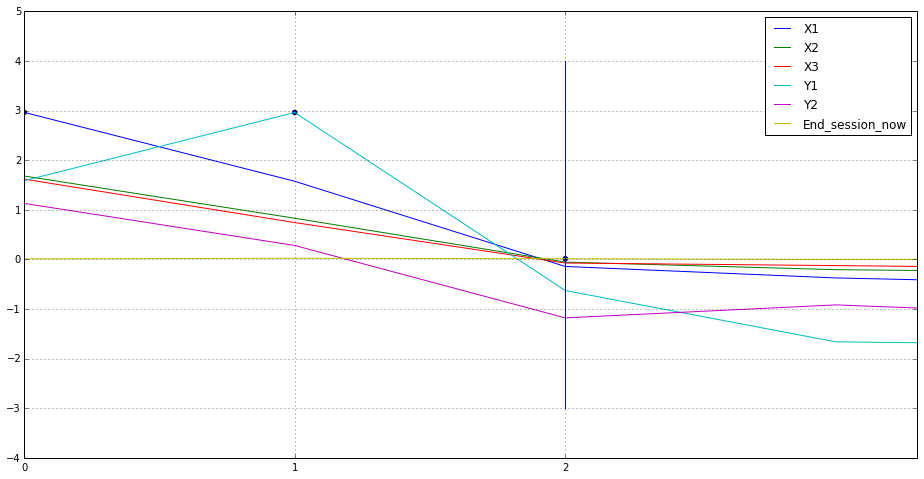

In [21]:
resolver.epsilon.set_value(np.float32(0.))
print "Random session examples"
env.generate_new_data_batch(10)
display_sessions(with_plots=True)
